# Convolutional Neural Network - Primer

In [ ]:
from IPython.display import Image
from IPython.display import display
%matplotlib inline

##  The building blocks of convolutional neural networks


CNN inspired by the functioning of the visual cortex in our brain.
Experiment in 1959 with an anesthetized cat.
Neurons respond differently after projecting different patterns of light in front of the cat.
Primary layers of the viual cortex detects edges and straight lines, highger order layers focus more on extracting complex shapes.  

In CNN, early layers extract low-level features from the raw data, later layers (often fully connected as in MLP) use these features to predict a target value.

CNN typically perform well on image data.

CNN performs well on image-related tasks largely due to two ideas:

* **Sparse connectivity**: A single element in the feature map (output of the convolutional layer) is connected to only a small patch of pixels. This is very different from MLP (connections to the whole image).

* **Parameter sharing**: The same weights are used for different patches of the input image using the same filter.

CNN made of following layers:

* convolutional -> have learnable parameters

* subsampling (Pooling layers) -> no learnable parameters

* fully connected -> have learnable parameters


## Performing discrete convolutions in 2D

Convolution applies a small filter (kernel) over the input x, allowing it to detect local structures like edges, textures, and patterns.

![2D convolution](https://miro.medium.com/v2/resize:fit:658/1*GcI7G-JLAQiEoCON7xFbhg.gif)

Note that the demonstration of convolution is only done for 1 channel. But if there are more than one channels, the convolution is applied to each channel separately and summed up as shown in reference [here](https://miro.medium.com/v2/resize:fit:1600/1*ciDgQEjViWLnCbmX-EeSrA.gif)


The discrete **2D convolution** of an image $ I $ with a kernel (filter) $ K $ is defined as:

$$
S(i, j) = (I * K)(i, j) = \sum_{m=-k}^{k} \sum_{n=-l}^{l} I(i - m, j - n) \cdot K(m, n)
$$

**Where**:

- $ S(i, j) $: Output value at position $(i, j)$,
- $ I(i - m, j - n) $: Input image pixel at offset $(m, n)$,
- $ K(m, n) $: Kernel value at $(m, n)$,
- $ k = \left\lfloor \frac{M}{2} \right\rfloor $, $ l = \left\lfloor \frac{N}{2} \right\rfloor $ for a kernel of size $ M \times N $.

**Notes**:

- The kernel $ K $ is usually flipped horizontally and vertically (standard convolution).
- Without flipping, the operation is **cross-correlation**, not convolution.
- Padding is commonly applied to maintain output dimensions.


## An example of 2D convolution

Consider the image below:


<img src="https://c8.alamy.com/comp/2C4JRDX/seamless-pattern-with-horizontal-and-vertical-black-lines-2C4JRDX.jpg" alt="Image of a pattern" width="600">

Let us apply 3x3 kernel to this image. To make it more intutive, let us apply a vertical edge kernel  and a horizontal edge kernel usually referred to as a **sobel filter**.

The vertical edge kernel is as follows:
$$
K_{\text{vertical}} = \begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$$

and horizontal edge kernel is as follows:
$$
K_{\text{horizontal}} = \begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}
$$

We can now perform the convolution operation as mentioned above.

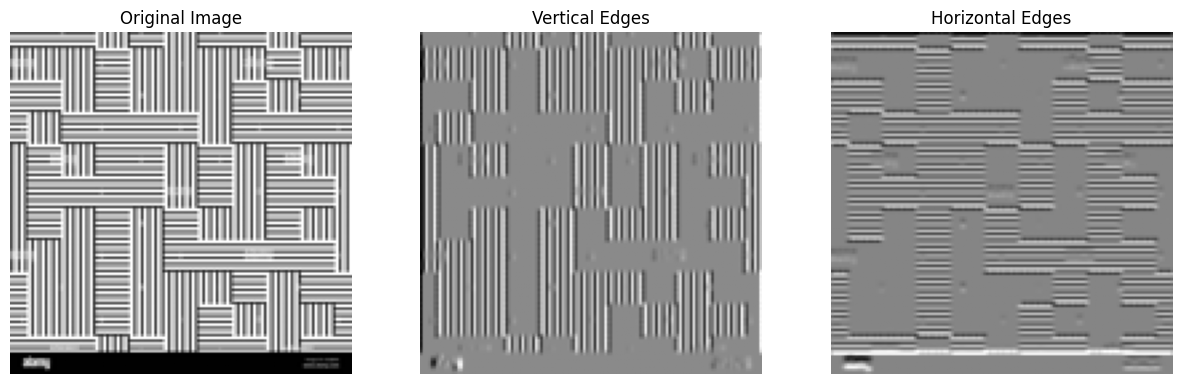

In [ ]:
import numpy as np

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt



def convolve2d(image, kernel):
    """
    Perform a 2D convolution without using scipy or other libraries.
    Args:
        image (ndarray): 2D input image.
        kernel (ndarray): 2D kernel/filter.
    Returns:
        output (ndarray): 2D output after applying convolution.
    """
    kernel = np.flipud(np.fliplr(kernel))  # flip the kernel
    kh, kw = kernel.shape
    ih, iw = image.shape
    pad_h, pad_w = kh // 2, kw // 2

    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(image)

    for i in range(ih):
        for j in range(iw):
            region = padded_image[i:i+kh, j:j+kw]
            output[i, j] = np.sum(region * kernel)

    return output

# Download a vertical and horizontal pattern image
url = "https://c8.alamy.com/comp/2C4JRDX/seamless-pattern-with-horizontal-and-vertical-black-lines-2C4JRDX.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('L').resize((128, 128))
img_np = np.array(img) / 255.0

# Define a vertical edge filter (Sobel)
vertical_filter = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]])

# Define a horizontal edge filter (Sobel)
horizontal_filter = np.array([[-1, -2, -1],
                              [ 0,  0,  0],
                              [ 1,  2,  1]])

# Apply convolution
vertical_edges = convolve2d(img_np, vertical_filter)
horizontal_edges = convolve2d(img_np, horizontal_filter)

# Plot results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img_np, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(vertical_edges, cmap='gray')
axs[1].set_title('Vertical Edges')
axs[1].axis('off')
axs[2].imshow(horizontal_edges, cmap='gray')
axs[2].set_title('Horizontal Edges')
axs[2].axis('off')
plt.show()

**Question**

Can you now, apply Gaussian blur to the image? Any guess on how the kernel would like? Also, can you perhaps think about an example of where you would use a Guassian blur ?

*Answer*

The Gaussian kernel is a 2D array of weights that is used to blur an image. The kernel is typically a square matrix with an odd number of rows and columns. The weights in the kernel are typically Gaussian distributions, which means that the weights are highest in the center of the kernel and decrease as you move away from the center.

An example of a Gaussian kernel is:

$$
K_{\text{Gaussian}} = \frac{1}{9} \begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{bmatrix}
$$
This kernel is a 3x3 matrix with weights that are all positive and sum to 1. The weights in the center of the kernel are the highest, and the weights decrease as you move away from the center.



## Padding inputs to control the size of the output feature maps

**`Why Padding Matters?`**
- Prevents excessive shrinking of feature maps in deep networks.
- Controls how much context the kernel sees near the edges.
- Balances computational efficiency vs. accuracy.


**1. `Full Padding`**
- **Adds the most padding** (zero-padding around the input).
- The output is **larger** than the input.
- Ensures that the kernel has a valid position even at the edges.


**2. `Same Padding`** (Most common in CNNs)
- **Adds just enough padding** so that the output size remains **the same** as the input size (assuming stride = 1).
- This helps preserve spatial dimensions throughout the layers.


**3. `Valid Padding`** (No Padding)
- **No padding is added**, meaning the kernel only moves over the valid input positions.
- The output is **smaller** than the input.


Here is a demonstration of these padding types in 1D. For 2D (or n-D), the concept is the same.

![Padding types](https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/Fig4_lec10.png)





### Determining the size of the convolution output

The output size $ o $ of a convolution operation is given by the formula:

$$
o = \left\lfloor \frac{n + 2p - m}{s} \right\rfloor + 1
$$

### Where:
- $ o $: output size (number of elements along that dimension),
- $ n $: input size (e.g., image width or height),
- $ m $: filter/kernel size,
- $ p $: amount of zero-padding applied to both sides,
- $ s $: stride (step size for the kernel),
- $ \lfloor \cdot \rfloor $: floor operation, which rounds down to the nearest integer.

### Interpretation:
- Padding increases the effective input size.
- Larger stride reduces the output size by skipping positions.
- This formula is used **per dimension**, so apply it separately for width and height in 2D convolutions.

### Example:
If you have an input of size 32, kernel size 5, padding 2, and stride 1:

$$
o = \left\lfloor \frac{32 + 2 \cdot 2 - 5}{1} \right\rfloor + 1 = \left\lfloor \frac{31}{1} \right\rfloor + 1 = 31 + 1 = 32
$$

This gives the same output size as the input.

In [ ]:
import torch
import numpy as np

print('PyTorch version:', torch.__version__)
print('NumPy version: ', np.__version__)

PyTorch version: 2.6.0+cu124
NumPy version:  2.0.2


## Subsampling layers -- Pooling layers

Pooling layers are used to reduce the dimensionality of the feature maps. This helps to reduce the computational cost of the network and to make the network more robust to small variations in the input.

There are two types of pooling layers:

1. Max pooling: The max pooling layer takes the maximum value of the feature map.
2. Average pooling: The average pooling layer takes the average value of the feature map.

The pooling layers are applied after the convolutional layers. The pooling layers do not have any trainable parameters.

![Pooling layers](https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/Fig7_lec10.png)


## Putting everything together – implementing a CNN

**Working with multiple input or color channels**



In the following example:

* The input has 3 channels

* Each filter has a depth of 3, matching the number of input channels.

* The number of filters (C_out = 5) determines the number of output feature maps. Each filter produces one feature map, meaning the output has 5 feature maps.

* A pooling operation (e.g., max pooling, average pooling) is applied.

It reduces spatial dimensions while maintaining 5 feature maps

![CNN workflow](https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/Fig8_lec10.png)


### The multilayer CNN architecture with PyTorch

![CNN architecture](https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/Fig10_lec10.png)

N.b.:

* **Convolution**: default values of stride=1, padding=0 [https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html]

* **Pooling**: default value of stride = kernel size [https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html]
